# Model Performance

## Prerequisites

Install python packages


In [1]:
%%capture
%pip install pandas pydicom pydicom-seg scikit-learn seaborn requests
%pip install segmentationmetrics

## Import required python packages


In [2]:
import warnings

warnings.filterwarnings("ignore")

import io
import zipfile
from collections.abc import Iterable
from pathlib import Path
from typing import Union

import cc3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
import pydicom_seg
import requests
import scipy.stats as stats
import seaborn as sns
import segmentationmetrics as sm
import SimpleITK as sitk
from segmentationmetrics.surface_distance import compute_surface_dice_at_tolerance
from tqdm.auto import tqdm

sns.set_theme(style="whitegrid")
%matplotlib inline

In [3]:
plt_colors = {
    "ne2": "#5eceb0",
    "rad1": "#9e70e1",
    "tp": "k",
    "fp": "b",
    "fn": "r",
}

revewer_cmap = sns.color_palette([plt_colors["ne2"], plt_colors["rad1"]])
vol_cmap = sns.color_palette([plt_colors["fp"], plt_colors["fn"]])

## Download the segmentation results from zenodo


In [4]:
qa_dir = Path("qa-results")

In [5]:
def download_inference(
    extract_dir="qa-results", record="13244892", filename="brain-mr.zip"
):
    url = f"https://zenodo.org/record/{record}/files/{filename}"
    # download the zip file and extract it
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_dir)


if not qa_dir.exists() or not (qa_dir / "ai-segmentations-dcm").exists():
    download_inference(qa_dir)

In [6]:
def load_dcm_seg(seg_path: Path, label_remap: dict) -> sitk.Image:
    dcm = pydicom.dcmread(str(seg_path))
    reader = pydicom_seg.SegmentReader()
    result = reader.read(dcm)
    tmp_img = result.segment_image(list(result.available_segments)[0])
    tmp_arr = np.zeros_like(sitk.GetArrayFromImage(tmp_img))

    for label in label_remap:
        if label in result.available_segments:
            arr = sitk.GetArrayFromImage(result.segment_image(label))
            tmp_arr[arr > 0] = label_remap[label]
    image = sitk.GetImageFromArray(tmp_arr)
    image.CopyInformation(tmp_img)
    image = sitk.Cast(image, sitk.sitkUInt8)
    return image


def load_nii_seg(seg_path: Path, label_remap: dict) -> sitk.Image:
    img = sitk.ReadImage(str(seg_path))
    # get list of all labels
    shape_filt = sitk.LabelShapeStatisticsImageFilter()
    shape_filt.Execute(img)
    all_labels = shape_filt.GetLabels()
    for label in all_labels:
        if label not in label_remap:
            label_remap[label] = 0

    # remap labels
    img = sitk.ChangeLabel(img, label_remap)
    img = sitk.Cast(img, sitk.sitkUInt8)

    return img


def load_seg(seg_path: Path, labels: Union[int, tuple, dict] = 1) -> sitk.Image:
    # convert labels to dictionary
    if isinstance(labels, int):
        labels = {labels: 1}
    elif isinstance(labels, Iterable):
        labels = {label: 1 for label in labels}

    if seg_path.suffix == ".dcm":
        return load_dcm_seg(seg_path, labels)
    else:
        return load_nii_seg(seg_path, labels)


def resize_label(img: sitk.Image, ref_img: sitk.Image, interp=sitk.sitkNearestNeighbor):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ref_img)
    resampler.SetInterpolator(interp)
    resampler.SetDefaultPixelValue(0)
    resampled_img = resampler.Execute(img)
    return resampled_img


def calc_metrics_for_label(
    ai_seg_file,
    qa_seg_file,
    fname,
    label_value=1,
    version="aimiv2",
    label_suffix="",
    nsd_tol=7,
):
    ai_img = load_seg(ai_seg_file, label_value)
    qa_img = load_seg(qa_seg_file, label_value)
    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    ai_arr = sitk.GetArrayFromImage(ai_img)
    qa_arr = sitk.GetArrayFromImage(qa_img)
    spacing = ai_img.GetSpacing()[::-1]  # numpy is reversed dimensions from sitk

    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    m = sm.SegmentationMetrics(ai_arr, qa_arr, spacing)
    metrics = {
        "dice": m.dice,
        "hausdorff_distance_95": m.hausdorff_distance,
        "mean_surface_distance": m.mean_surface_distance,
        "normalized_surface_distance": compute_surface_dice_at_tolerance(
            m._surface_dist, nsd_tol
        ),
        "SeriesUID": fname,  # from medical segmentation decathlon
        "label": label_value,
        "version": version,
        "normalized_surface_distance_tolerance": nsd_tol,
    }

    if label_suffix:
        metrics = {f"{k}_{label_suffix}": v for k, v in metrics.items()}
    return metrics


def con_comp(seg_array):
    # input: a binary segmentation array output: an array with seperated (indexed) connected components of the segmentation array
    connectivity = 18
    conn_comp = cc3d.connected_components(seg_array, connectivity=connectivity)
    return conn_comp


def get_discovery_rates(
    img_file_pred: str, img_file_gt: str, label_value: int = 1, prefix=""
):
    img_pred = load_seg(img_file_pred, label_value)
    img_gt = load_seg(img_file_gt, label_value)
    img_gt = resize_label(img_gt, img_pred)  # match the size of the qa_img
    gt_arr = sitk.GetArrayFromImage(img_gt)
    pred_arr = sitk.GetArrayFromImage(img_pred)
    voxel_vol = np.prod(img_pred.GetSpacing()) / 1000

    assert pred_arr.shape == gt_arr.shape, "Shape mismatch"
    # check that pred_array is binary
    assert set(np.unique(pred_arr)) in ({0}, {0, 1}), "pred_array is not binary"
    # check that gt_array is binary
    assert set(np.unique(gt_arr)) in ({0}, {0, 1}), "gt_array is not binary"

    pred_offset = pred_arr.copy()
    pred_offset[pred_offset == 1] = 2  # reset pred_array to 0,2

    combined = pred_offset + gt_arr
    tp = (combined == 3).sum() * voxel_vol
    fp = (combined == 2).sum() * voxel_vol
    fn = (combined == 1).sum() * voxel_vol

    tp_s = []
    false_pos_vols_ml = []
    false_neg_vols_ml = []

    pred_cc = con_comp(pred_arr)
    for idx in range(1, pred_cc.max() + 1):
        comp_mask = np.isin(pred_cc, idx)
        vals, cnts = np.unique(combined[comp_mask], return_counts=True)
        dect_arr = {v: c for v, c in zip(vals.tolist(), cnts.tolist())}

        if 0 in dect_arr:
            raise ValueError("should be no 0 values in the label")
        if 1 in dect_arr:
            raise ValueError("should be no 1 values in the label")
        if 3 in dect_arr:
            tp_s.append(
                (dect_arr[3], dect_arr.get(2, 0))
            )  # (true positive, false positive)
            pass  # true positive, overlaps with gt
        elif 2 in dect_arr and 1 in dect_arr:
            raise ValueError("should not be 2 and 1 values in the label")
        elif 2 in dect_arr:
            false_pos_vols_ml.append(
                dect_arr[2] * voxel_vol
            )  # false positive, does not overlap with gt
        # elif 1 in dect_arr:
        #     false_neg_vols_ml.append(
        #         dect_arr[1] * voxel_vol
        #     )  # false negative, does not overlap with pred

    gt_cc = con_comp(gt_arr)
    for idx in range(1, gt_cc.max() + 1):
        comp_mask = np.isin(gt_cc, idx)
        vals, cnts = np.unique(combined[comp_mask], return_counts=True)
        dect_arr = {v: c for v, c in zip(vals.tolist(), cnts.tolist())}

        if 0 in dect_arr:
            raise ValueError("should be no 0 values in the label")
        if 2 in dect_arr:
            raise ValueError("should be no 2 values in the label")
        elif 1 in dect_arr:
            false_neg_vols_ml.append(
                dect_arr[1] * voxel_vol
            )  # false negative, does not overlap with pred
        if 3 in dect_arr:
            continue  # true positive, overlaps with pred
        elif 2 in dect_arr and 1 in dect_arr:
            raise ValueError("should not be 2 and 1 values in the label")

    stats = {
        # "true_vol_overlap_ml": true_vol_overlap_ml,
        "false_pos_vols_ml": false_pos_vols_ml,
        "false_neg_vols_ml": false_neg_vols_ml,
        # "true_vol_overlap_ml_total": sum(true_vol_overlap_ml),
        "true_pos_pix_vol_ml_total": tp,
        "false_pos_pix_vol_ml_total": fp,
        "false_neg_pix_vol_ml_total": fn,
        "false_pos_roi_vol_ml_total": sum(false_pos_vols_ml),
        "false_neg_roi_vol_ml_total": sum(false_neg_vols_ml),
        "true_pos_roi_cnt": len(tp_s),
        "false_pos_roi_cnt": len(false_pos_vols_ml),
        "false_neg_roi_cnt": len(false_neg_vols_ml),
    }
    stats["pos_roi_cnt"] = stats["true_pos_roi_cnt"] + stats["false_neg_roi_cnt"]

    if prefix:
        stats = {f"{prefix}-{k}": v for k, v in stats.items()}

    return stats

In [7]:
# Load the CSV file
df = pd.read_csv(Path("qa-results/qa-results.csv"))
qa_df = df[df.Validation]

# Paths for aimiv1, aimiv2, and qa
ai_path = Path("qa-results/ai-segmentations-dcm")
qa_path = Path("qa-results/qa-segmentations-dcm")

In [8]:
# labels and tolerances
label_names = {1: "necrosis", 2: "edema", 3: "enhancing tumor"}
nsd_tolerances = {1: 5, 2: 5, 3: 5}  # per label tolerances in mm

In [9]:
# verify that the labels in the dcm file match the expected labels
ds = pydicom.dcmread(ai_path / df.AISegmentation.iloc[0])
result = pydicom_seg.SegmentReader().read(ds)
label_names_from_dcm = {
    k: v["SegmentDescription"].value for k, v in result.segment_infos.items()
}
assert (
    label_names_from_dcm == label_names
), "labels in the dcm file do not match expected labels"

In [10]:
# Initialize lists for metrics
metrics = []

# Iterate over all QA cases
for _, row in tqdm(qa_df.iterrows(), total=len(qa_df)):
    ai_file = ai_path / row.AISegmentation
    if not pd.isna(row.CorrectedSegmentation):
        qa_file = qa_path / row.CorrectedSegmentation
    else:
        # reviewer had no corrections, use AI segmentation as QA
        qa_file = ai_file

    assert ai_file.exists(), f"AI segmentation not found for {row.AISegmentation}"
    assert qa_file.exists(), f"QA segmentation not found for {row.QASegmentation}"

    version = "aimiv1" if row.AimiProjectYear == 2023 else "aimiv2"
    for label_value in [1, 2, 3]:
        stats = calc_metrics_for_label(
            ai_file,
            qa_file,
            row.SeriesInstanceUID,
            version=version,
            label_value=label_value,
            nsd_tol=nsd_tolerances[label_value],
        )
        stats["label_name"] = label_names[label_value]
        metrics.append(stats)

    # get metrics for Brats labels: WT (NET, Edema, ET) & Tumor Core (NET,ET)
    whole_tumor_stats = calc_metrics_for_label(
        ai_file,
        qa_file,
        row.SeriesInstanceUID,
        version=version,
        label_value=(1, 2, 3),
        nsd_tol=5,
    )
    whole_tumor_stats["label"] = "whole_tumor"
    whole_tumor_stats["label_name"] = "whole_tumor"
    metrics.append(whole_tumor_stats)

    tumor_core_stats = calc_metrics_for_label(
        ai_file,
        qa_file,
        row.SeriesInstanceUID,
        version=version,
        label_value=(1, 3),
        nsd_tol=5,
    )
    tumor_core_stats["label"] = "tumor_core"
    tumor_core_stats["label_name"] = "tumor_core"
    metrics.append(tumor_core_stats)


metrics_df = pd.DataFrame.from_records(metrics)

# Replace infinite values with NaN and drop NaN values
metrics_df = metrics_df.replace([np.inf, -np.inf], np.nan).dropna()

  0%|          | 0/55 [00:00<?, ?it/s]

In [11]:
metrics_df.to_csv("qa-metrics.csv", index=False)

In [12]:
aggregated_df = (
    metrics_df.groupby(["label_name", "version"])
    .agg(
        {
            "dice": ["mean", "std"],
            "hausdorff_distance_95": ["mean", "std"],
            "mean_surface_distance": ["mean", "std"],
            "normalized_surface_distance": ["mean", "std"],
            "normalized_surface_distance_tolerance": "first",
        }
    )
    .round(2)
)
aggregated_df

dice       hausdorff_distance_95        \
                         mean   std                  mean   std   
label_name      version                                           
edema           aimiv2   0.98  0.07                  1.98  4.83   
enhancing tumor aimiv2   0.95  0.13                  3.12  7.73   
necrosis        aimiv2   0.96  0.16                  0.93  2.68   
tumor_core      aimiv2   0.96  0.13                  3.52  7.79   
whole_tumor     aimiv2   0.98  0.06                  2.31  5.22   

                        mean_surface_distance        \
                                         mean   std   
label_name      version                               
edema           aimiv2                   0.18  0.42   
enhancing tumor aimiv2                   0.38  1.00   
necrosis        aimiv2                   0.15  0.59   
tumor_core      aimiv2                   0.48  1.17   
whole_tumor     aimiv2                   0.27  0.61   

                        normalized_surface_distance        \
                                               mean   std   
label_name      version                                     
edema           aimiv2                         0.99  0.03   
enhancing tumor aimiv2                         0.96  0.11   
necrosis        aimiv2                         0.98  0.11   
tumor_core      aimiv2                         0.96  0.12   
whole_tumor     aimiv2                         0.98  0.05   

                        normalized_surface_distance_tolerance  
                                                        first  
label_name      version                                        
edema           aimiv2                                      5  
enhancing tumor aimiv2                                      5  
necrosis        aimiv2                                      5  
tumor_core      aimiv2                                      5  
whole_tumor     aimiv2                                      5

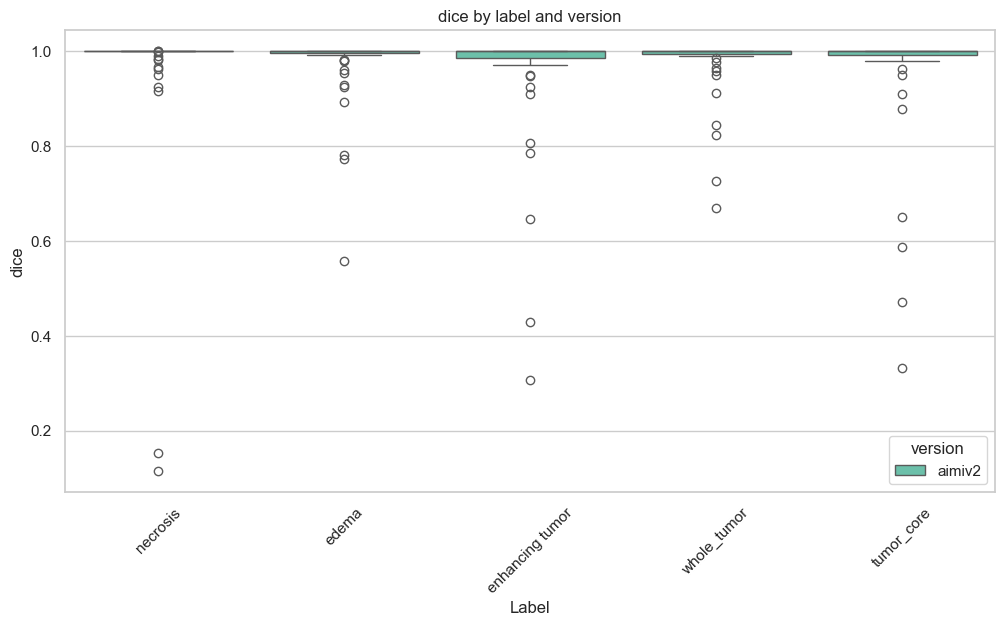

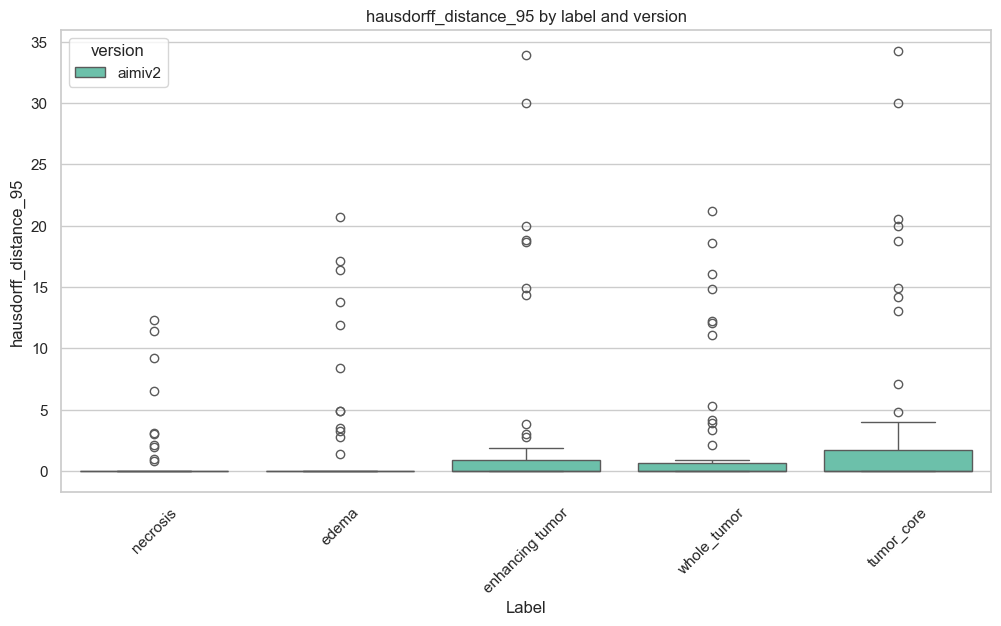

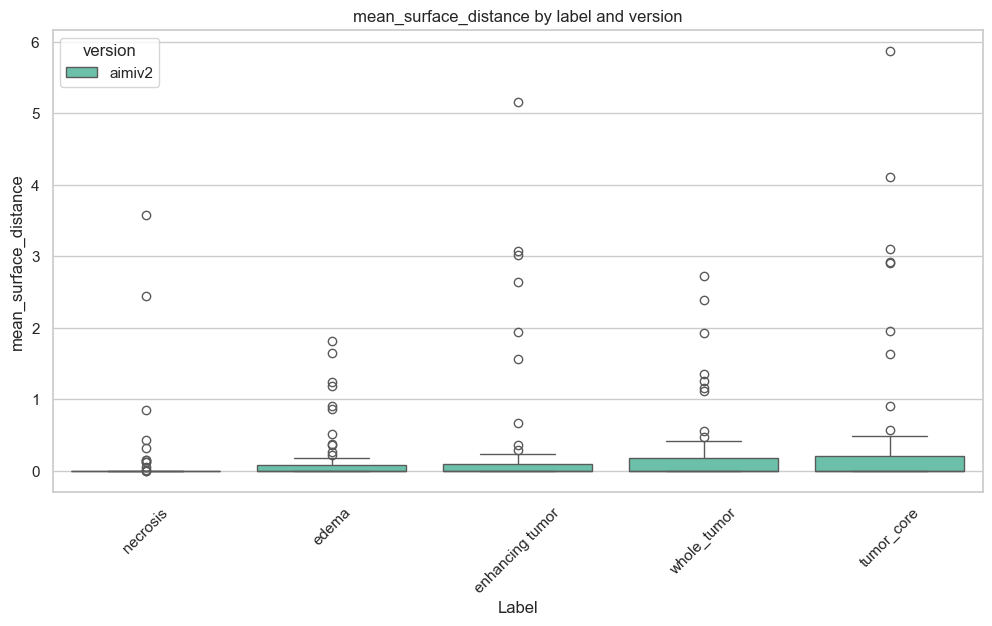

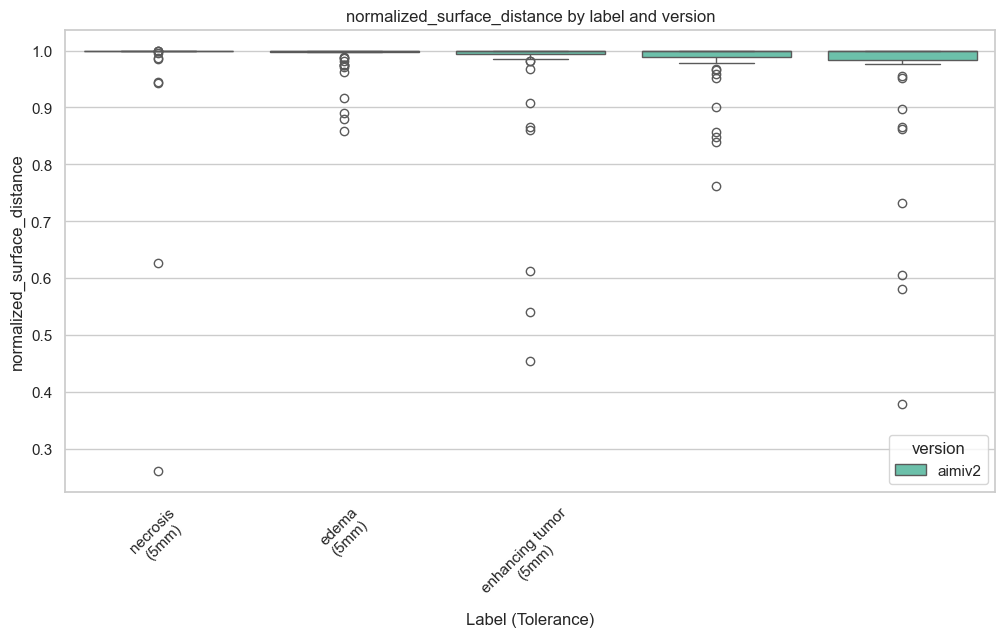

In [13]:
# create seaborn categorical boxplot for each metric, by label and version
for metric in [
    "dice",
    "hausdorff_distance_95",
    "mean_surface_distance",
    "normalized_surface_distance",
]:
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(
        x="label_name",
        y=metric,
        hue="version",
        data=metrics_df,
        palette=revewer_cmap,
        ax=ax,
    )
    if metric == "normalized_surface_distance":
        # set x axis labels to be 'label name (tolerance)'
        labels = [
            f"{label_name}\n({nsd_tolerances[label_value]}mm)"
            for label_value, label_name in label_names.items()
        ]
        ax.set_xticklabels(labels)
        ax.set_xlabel("Label (Tolerance)")
    else:
        ax.set_xlabel("Label")

    ax.set_title(f"{metric} by label and version")
    ax.set_ylabel(metric)
    plt.xticks(rotation=45)
    plt.show()